<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/ClimatePrediction/blob/master/Predict_Rain_MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Nomes para as colunas
columns = ["Estacao","Data","Hora","Prec","TempMax","TempMin","Insolacao","EvapoPiche","TempCompMedia",
           "UmidRelatMedia", "VelocVento", "Missing"]

#Tipos de dados em cada coluna
types = {"Hora":np.uint16,"Prec":np.float64,"TempMax":np.float64,"TempMin":np.float64,"Insolacao":np.float64,
         "EvapoPiche":np.float64,"TempCompMedia":np.float64,"UmidRelatMedia":np.float64,"VelocVento":np.float64}

#Leitura do arquivo csv
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/ClimatePrediction/raw/master/Dados_INMET/Diarios/INMET-Dados_Diarios_Natal_1968-2018.csv",
                      sep=';',skiprows=48, nrows = 27003, usecols = columns[1:11], names=columns, dtype = types)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [0]:
#Verificando dados
dataSet.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,1968-01-01,0,NaN,30.6,NaN,11.1,4.4,25.14,73.50,2.666667
1,1968-01-01,1200,0.0,NaN,21.4,NaN,NaN,NaN,NaN,NaN
2,1968-01-02,0,NaN,31.0,NaN,11.9,6.5,24.92,74.75,1.666667
3,1968-01-02,1200,0.0,NaN,19.6,NaN,NaN,NaN,NaN,NaN
4,1968-01-03,0,NaN,31.6,NaN,11.3,5.0,24.90,77.25,2.333333


In [0]:
#Verificando o tipo dos dados
dataSet.dtypes

Data              datetime64[ns]
Hora                      uint16
Prec                     float64
TempMax                  float64
TempMin                  float64
Insolacao                float64
EvapoPiche               float64
TempCompMedia            float64
UmidRelatMedia           float64
VelocVento               float64
dtype: object

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,1968-01-01,0,NaN,30.6,NaN,11.1,4.4,25.14,73.50,2.666667
2,1968-01-02,0,NaN,31.0,NaN,11.9,6.5,24.92,74.75,1.666667
4,1968-01-03,0,NaN,31.6,NaN,11.3,5.0,24.90,77.25,2.333333
6,1968-01-04,0,NaN,31.2,NaN,10.3,4.0,24.82,80.75,3.666667
8,1968-01-05,0,NaN,30.8,NaN,11.0,4.2,24.78,76.00,4.000000


In [0]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
1,1968-01-01,1200,0.0,NaN,21.4,NaN,NaN,NaN,NaN,NaN
3,1968-01-02,1200,0.0,NaN,19.6,NaN,NaN,NaN,NaN,NaN
5,1968-01-03,1200,0.0,NaN,18.5,NaN,NaN,NaN,NaN,NaN
7,1968-01-04,1200,0.0,NaN,20.7,NaN,NaN,NaN,NaN,NaN
9,1968-01-05,1200,0.0,NaN,19.9,NaN,NaN,NaN,NaN,NaN


In [0]:
#Transformando a data no índice de cada dataframe
dataSet00 = dataSet00.set_index("Data")
dataSet12 = dataSet12.set_index("Data")

In [0]:
#Descartando a coluna "Hora"
dataSet00, dataSet12 = dataSet00.drop(columns = "Hora"), dataSet12.drop(columns = "Hora")

In [0]:
#Juntando os dados em um mesmo dataframe (no caso, o dataSet00)
for i in dataSet00.index:
    try:
        dataSet00["Prec"].loc[i] = dataSet12["Prec"].loc[i]
        dataSet00["TempMin"].loc[i] = dataSet12["TempMin"].loc[i]
    except:
        print("Data " + str(i.day) + "/" + str(i.month) + "/" + str(i.year) + " Não encontrada!")

Data 5/7/1986 Não encontrada!
Data 20/7/1986 Não encontrada!
Data 3/6/1989 Não encontrada!
Data 12/6/1989 Não encontrada!
Data 4/12/1992 Não encontrada!
Data 26/5/2018 Não encontrada!
Data 1/8/2018 Não encontrada!
Data 27/10/2018 Não encontrada!


In [0]:
#Atribuindo à variável dataSet o DataFrame atualizado
dataSet = dataSet00
#Verificando dimensões do DataFrame
print(dataSet.shape)

(13502, 8)


In [0]:
#Transformando a coluna Data de volta em uma coluna de informações do dataSet
dataSet = dataSet.reset_index()

In [0]:
#Eliminando da base de dados dias com variáveis faltantes
dataSet = dataSet.dropna()
#Exibindo novas dimensões da base de dados
print(dataSet.shape)

(11911, 9)


# Considerando os seguintes intervalos: 
- Outono: 20 de março a 21 de junho (fechado em 20/03 e aberto em 21/06)
- Inverno: 21 de junho a 22 de setembro (fechado em 21/06 e aberto em 22/09)
- Primavera: de 22 de setembro a 21 de dezembro (fechado em 22/09 e aberto em 21/12)
- Verão: de 21 de dezembro a 20 de março (fechado em 21/12 e aberto em 20/03)

In [0]:
#Função que retorna a estação do ano para uma determinada data, para ser adicionada à base de dados
def season(data):
    if (data.month > 3 and data.month < 6) or (data.month == 3 and data.day >= 20) or (data.month == 6 and data.day < 21):
        return "Out"
    if (data.month > 6 and data.month < 9) or (data.month == 6 and data.day >= 21) or (data.month == 9 and data.day < 22):
        return "Inv"
    if (data.month > 9 and data.month < 12) or (data.month == 9 and data.day >= 22) or (data.month == 12 and data.day < 21):
        return "Pri"
    else:
        return "Ver"

In [0]:
#Identificando a estação do ano na base de dados e guardando a informação referente ao ano de cada dado
estacao = []
for i in dataSet.index:
    estacao.insert(i, season(dataSet.loc[i, "Data"]))

In [0]:
#Contando quantos dados existem para cada estação
print("Outono: " + str(estacao.count("Out")))
print("Inverno: " + str(estacao.count("Inv")))
print("Primavera: " + str(estacao.count("Pri")))
print("Verão: " + str(estacao.count("Ver")))

Outono: 3048
Inverno: 2988
Primavera: 2946
Verão: 2929


In [0]:
#Eliminando a coluna "Data" e visualizando dados
dataSet = dataSet.drop(columns="Data")
dataSet.head()

,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,0.0,30.6,21.4,11.1,4.4,25.14,73.50,2.666667
1,0.0,31.0,19.6,11.9,6.5,24.92,74.75,1.666667
2,0.0,31.6,18.5,11.3,5.0,24.90,77.25,2.333333
3,0.0,31.2,20.7,10.3,4.0,24.82,80.75,3.666667
4,0.0,30.8,19.9,11.0,4.2,24.78,76.00,4.000000


In [0]:
#Decodificando as estações em uma matriz (one hot encoding - dummy variables)
encoder = LabelEncoder()
encoder.fit(estacao)
encodedSeason = encoder.transform(estacao)
dummySeason = np_utils.to_categorical(encodedSeason)

In [0]:
#Identificar como aconteceu a transformação
auxSeason = encoder.transform(["Inv","Out","Pri","Ver"])
auxDummy = np_utils.to_categorical(auxSeason)
print("[Inv,Out,Pri,Ver]")
print(auxDummy)

[Inv,Out,Pri,Ver]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [0]:
#Separando a variável que será prevista, precipitação, da base de dados
prec = dataSet["Prec"]
dataSet = dataSet.drop(columns = "Prec")

In [0]:
#Adicionando ao dataSet as informações de estação climática
dataSet["Inv"] = dummySeason[:,0]
dataSet["Out"] = dummySeason[:,1]
dataSet["Pri"] = dummySeason[:,2]
dataSet["Ver"] = dummySeason[:,3]

In [0]:
#Visualizando dados
dataSet.head()

,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento,Inv,Out,Pri,Ver
0,30.6,21.4,11.1,4.4,25.14,73.50,2.666667,0.0,0.0,0.0,1.0
1,31.0,19.6,11.9,6.5,24.92,74.75,1.666667,0.0,0.0,0.0,1.0
2,31.6,18.5,11.3,5.0,24.90,77.25,2.333333,0.0,0.0,0.0,1.0
3,31.2,20.7,10.3,4.0,24.82,80.75,3.666667,0.0,0.0,0.0,1.0
4,30.8,19.9,11.0,4.2,24.78,76.00,4.000000,0.0,0.0,0.0,1.0


In [0]:
#Separando conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(dataSet, prec, test_size = 0.1, random_state = 9)

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 11, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = 11, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer=init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae', 'msle'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [20,30],             
              'camadas': [2],
              'units': [11,15]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, n_jobs = -1,
                     scoring = "neg_mean_absolute_error", verbose=50, cv = kfold, return_train_score = True)

In [0]:
#Busca pelos melhores parâmetros
grid_result = grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.9

In [0]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -4.001008, usando {'batch_size': 20, 'camadas': 2, 'units': 11}
Resultados (Desvio padrão) {Parâmetros}
-4.001008 (0.153919) {'batch_size': 20, 'camadas': 2, 'units': 11}
-4.117252 (0.172824) {'batch_size': 20, 'camadas': 2, 'units': 15}
-4.188511 (0.168735) {'batch_size': 30, 'camadas': 2, 'units': 11}
-4.150350 (0.183767) {'batch_size': 30, 'camadas': 2, 'units': 15}


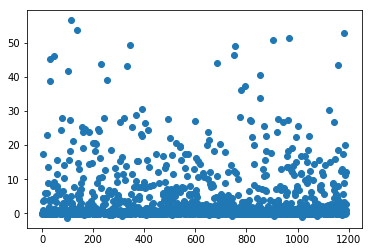

In [0]:
#Gráfico de distribuição da previsão para o conjunto de teste
plt.scatter(list(range(len(grid_search.predict(X_test)))), grid_search.predict(X_test))

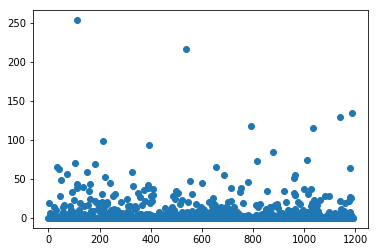

In [0]:
#Gráfico de distribuição das variáveis de teste reais
plt.scatter(list(range(len(Y_test))), Y_test)

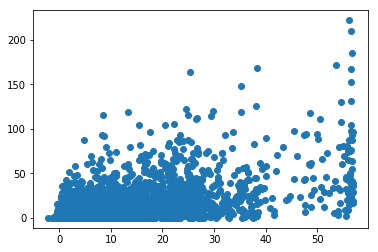

In [0]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_search.predict(X_train), Y_train)

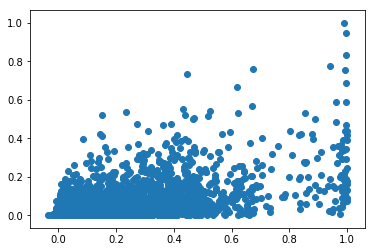

In [0]:
#Gráfico de previsão para o conjunto de treino normalizado
plt.scatter(grid_search.predict(X_train) / max(grid_search.predict(X_train)), Y_train / max(Y_train))

In [0]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_train, grid_search.predict(X_train)))

[[1.         0.64660564]
 [0.64660564 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_pred = grid_search.predict(X_test)

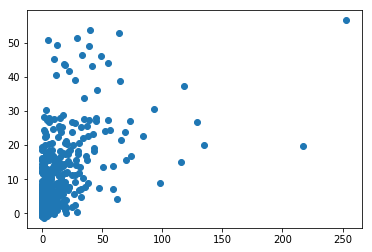

In [0]:
#Gráfico que mostra a relação entre a chuva real e a prevista
plt.scatter(Y_test, Y_pred)

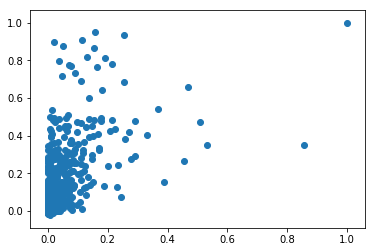

In [0]:
#Gráfico normalizado que mostra a relação entre a chuva real e a prevista
plt.scatter(Y_test / max(Y_test), Y_pred / max(Y_pred))

In [0]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_test, grid_search.predict(X_test)))

[[1.         0.58718983]
 [0.58718983 1.        ]]


In [0]:
#Erro absoluto médio entre a chuva prevista e a real
print(mean_absolute_error(Y_test, Y_pred))

4.401213127174634


In [0]:
#Erro quadrático médio entre a chuva prevista e a real
print(mean_squared_error(Y_test, Y_pred))

172.64972720443023
